>> 1. Fine Tuning

전이 학습을 할때 우리는 Convolution Layer가 있는 특징을 추출하는 부분을 고정시키고 학습하였습니다. 

그러나, 이 방식으로 정확도가 어느 정도 수준에서 올라가지 않는다면, 
Convolution Layer의 일부 층을 추가 학습을 해서
특징 추출하는 부분이 학습 데이터의 특징을 더 잘 인식할 수 있도록 만들 수 있습니다. 




이전 강의의 VGG 모델의 Convolution Layer 부분이 특징을 추출하는 모습을 살펴봅시다.

우선 데이터와 모델을 불러오겠습니다. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/Tensorflow AI/New Masks Dataset'

img_height = 150
img_width = 150

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Train',    
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Validation',    
  image_size=(img_height, img_width))

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Test',    
  image_size=(img_height, img_width))

Found 600 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


Transfer Learning에서 활용한 VGG 모델을 불러와보겠습니다. 

include_top = False를 설정한 경우 이미지를 분류하는 Fully Connected Layer가 없습니다. 

In [3]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights = 'imagenet',include_top=False, input_shape=(150,150,3))
vgg_model.trainable = False

In [4]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

이 모델에 이미지를 넣어보고 output이 어떤 형태인지 살펴봅시다

In [5]:

for imgs, lbs in test_ds.take(1):
  pred = vgg_model.predict(imgs)

In [6]:
pred.shape

(32, 4, 4, 512)

vgg 출력은 이미지당 4 x 4 커널 512개가 나오게 됩니다. 

커널은 weight와 bias로 이루어져있습니다. 

In [7]:
pred[0,:,:,0]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

0번 이미지의 kernel 출력 일부를 시각화하여 살펴봅시다. 

kernel 마다 이미지의 다른 특징을 추출하여 다른 값을 가지고 있는 것을 알 수 있습니다. 

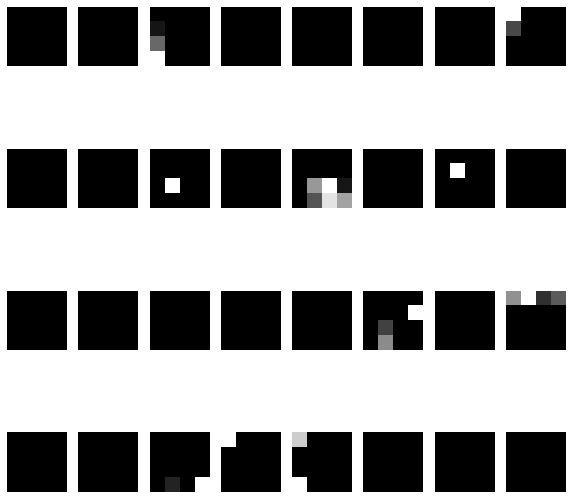

In [8]:
plt.figure(figsize=(10, 10))
for i in range(32):  
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(pred[0,:,:,i], cmap = 'gray')
  plt.axis("off")

사전 학습 모델이 학습한 데이터셋과 새로 학습 하는 데이터셋이 차이가 크다면 특징을 추출할 때 그것에 적합하도록 Covolution 부분을 수정해야 합니다. 

>> 2. Fine tuning으로 학습하기

Fine tuning을 하기 전에 우선 전이학습을 통해 높은 수준의 정확도를 나타낼 수 있도록 학습해 줍니다. 

그 후에 fine tuning을 통해 추가로 정확도를 높입니다. 

VGG 모델을 불러와서 Transfer Learning을 진행합니다. 
(기존에 정확도가 높았기 때문에 epoch를 줄여서 진행해보겠습니다. )

In [9]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights = 'imagenet',include_top=False, input_shape=(150,150,3))

In [10]:
vgg_model.trainable = False

In [11]:
from tensorflow.keras import Sequential, Model, layers
transfer_model = Sequential()

transfer_model.add(vgg_model)

transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(256,activation='relu'))
transfer_model.add(layers.Dropout(0.5))
transfer_model.add(layers.Dense(1,activation='sigmoid'))

transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


기존에 전이학습의 정확도가 매우 높았기 때문에 여기서는
epoch를 줄여서 학습을 진행하겠습니다. 

In [12]:
transfer_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = transfer_model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
19/19 [==============================] - 10s 448ms/step - loss: 3.4146 - acc: 0.9017 - val_loss: 1.0929 - val_acc: 0.9739
Epoch 2/5
19/19 [==============================] - 6s 288ms/step - loss: 0.9228 - acc: 0.9833 - val_loss: 1.2729 - val_acc: 0.9510
Epoch 3/5
19/19 [==============================] - 6s 288ms/step - loss: 1.0461 - acc: 0.9700 - val_loss: 1.1024 - val_acc: 0.9771
Epoch 4/5
19/19 [==============================] - 6s 290ms/step - loss: 0.6915 - acc: 0.9867 - val_loss: 1.1756 - val_acc: 0.9739
Epoch 5/5
19/19 [==============================] - 6s 290ms/step - loss: 0.2090 - acc: 0.9917 - val_loss: 1.1199 - val_acc: 0.9706


이렇게 학습한 후에 Convolution layer 일부를 학습 가능하도록 변경하고 추가학습을 진행합니다. 

이때는 학습률을 더 작게해서 학습이 천천히 진행되도록 합니다. 

위쪽의 15번에서 18번까지의 층을 학습 가능하도록 변경합니다. 


VGG는 19개의 층이 존재합니다. 이 중에서 15에서 18번째 층을 학습 가능하도록 변경하겠습니다. 

In [13]:
# 기본 모델에 몇 개의 층이 있는지 확인 합니다.
print("Number of layers in the base model: ", len(vgg_model.layers))

Number of layers in the base model:  19


In [14]:
vgg_model.trainable = True
fine_tune_at = 15
for layer in vgg_model.layers[:fine_tune_at]:
  layer.trainable =  False

vgg 모델이 학습가능한 파라미터가 생긴것을 확인할 수 있습니다

In [15]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

이제 추가 학습을 진행합니다. 

이때 Optimizer의 학습률을 더 작게해서 더 천천히 학습이 이뤄지도록 하겠습니다. 
adam의 기본 학습률은 0.001 이며, 이를 0.0001로 변경하여 진행하겠습니다 .


In [17]:
transfer_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['acc'])
history = transfer_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
19/19 [==============================] - 8s 315ms/step - loss: 2.4999e-10 - acc: 1.0000 - val_loss: 1.1192 - val_acc: 0.9706
Epoch 2/10
19/19 [==============================] - 6s 300ms/step - loss: 0.2067 - acc: 0.9967 - val_loss: 3.5901 - val_acc: 0.9608
Epoch 3/10
19/19 [==============================] - 6s 300ms/step - loss: 0.6088 - acc: 0.9767 - val_loss: 2.2889 - val_acc: 0.9608
Epoch 4/10
19/19 [==============================] - 7s 304ms/step - loss: 0.7012 - acc: 0.9733 - val_loss: 0.6715 - val_acc: 0.9542
Epoch 5/10
19/19 [==============================] - 7s 304ms/step - loss: 0.0271 - acc: 0.9950 - val_loss: 0.1789 - val_acc: 0.9771
Epoch 6/10
19/19 [==============================] - 6s 300ms/step - loss: 0.0675 - acc: 0.9883 - val_loss: 0.2339 - val_acc: 0.9804
Epoch 7/10
19/19 [==============================] - 6s 299ms/step - loss: 0.0320 - acc: 0.9983 - val_loss: 0.2260 - val_acc: 0.9837
Epoch 8/10
19/19 [==============================] - 6s 299ms/step - loss

In [18]:
# 테스트셋 정확도 평가

test_loss , test_acc = transfer_model.evaluate(test_ds)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 2s 308ms/step - loss: 0.0446 - acc: 0.9900
test acc :0.9900000095367432 test loss:0.04455021396279335
